**Anna Smith**

**GitHub username: acs-233**

**Imperial College London - MSc EDSML - IRP**
# **CNN to predict $\textnormal{BECO}_2\textnormal{N}$ data**

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, MaxPooling1D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import backend as K
from livelossplot import PlotLossesKeras

from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor

from pathlib import Path

In [4]:
from bayareaco2.models.data import fit_scaler, scale_features, drop_high_vif

## Reading in Data

In [37]:
path = Path.cwd().parent.parent.parent / 'Data' / 'CO2' / 'daily_avg_BEACO2N.csv'
co2 = pd.read_csv(path)

path = Path.cwd().parent.parent.parent / 'Data' / 'features.csv'
features = pd.read_csv(path)

# Merging data
df = co2.merge(features, on='node_id')

In [39]:
# Confirming no missing values
np.max(df.isna().sum())

0

In [40]:
df

,node_id,date,timestamp,co2,temp,pressure,rh,year,month,lat,...,avg_pop_dens_50m,avg_pop_dens_100m,avg_pop_dens_200m,avg_pop_dens_300m,avg_pop_dens_500m,avg_pop_dens_1000m,avg_pop_dens_2000m,avg_pop_dens_3000m,avg_pop_dens_4000m,avg_pop_dens_5000m
0,2,2015-02-03,2015-02-03 11:30:00.000000000,436.042374,16.980245,1015.074005,63.821168,2015,2,38.289,...,169.400000,169.400000,169.400000,169.400000,169.400000,169.400000,512.977544,720.457390,765.629357,724.831441
1,2,2015-02-04,2015-02-04 11:30:00.000000000,438.478472,15.822596,1013.333705,68.045385,2015,2,38.289,...,169.400000,169.400000,169.400000,169.400000,169.400000,169.400000,512.977544,720.457390,765.629357,724.831441
2,2,2015-03-14,2015-03-14 11:30:00.000000000,450.383408,22.581634,1013.953940,54.688219,2015,3,38.289,...,169.400000,169.400000,169.400000,169.400000,169.400000,169.400000,512.977544,720.457390,765.629357,724.831441
3,2,2015-03-15,2015-03-15 11:30:00.000000000,425.889624,19.821010,1013.194940,49.344820,2015,3,38.289,...,169.400000,169.400000,169.400000,169.400000,169.400000,169.400000,512.977544,720.457390,765.629357,724.831441
4,2,2015-03-16,2015-03-16 11:30:00.000000000,439.721886,18.596646,1013.002304,62.354269,2015,3,38.289,...,169.400000,169.400000,169.400000,169.400000,169.400000,169.400000,512.977544,720.457390,765.629357,724.831441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43897,286,2024-03-22,2024-03-22 11:30:00.000000000,434.502675,20.390149,1014.145432,49.324725,2024,3,37.847,...,15127.053329,15953.607262,16300.528823,16150.012015,16387.774742,14981.046811,12583.537953,12283.743192,10896.300370,9445.255071
43898,286,2024-03-23,2024-03-23 11:30:00.000000000,425.356008,18.448980,1009.636745,51.039510,2024,3,37.847,...,15127.053329,15953.607262,16300.528823,16150.012015,16387.774742,14981.046811,12583.537953,12283.743192,10896.300370,9445.255071
43899,286,2024-03-24,2024-03-24 11:30:00.000000000,421.349008,20.199887,1010.013281,42.642338,2024,3,37.847,...,15127.053329,15953.607262,16300.528823,16150.012015,16387.774742,14981.046811,12583.537953,12283.743192,10896.300370,9445.255071
43900,286,2024-03-25,2024-03-25 11:30:00.000000000,423.765209,20.338516,1014.235041,42.538865,2024,3,37.847,...,15127.053329,15953.607262,16300.528823,16150.012015,16387.774742,14981.046811,12583.537953,12283.743192,10896.300370,9445.255071


In [8]:
# Defining dependent variable
y = df['co2'].copy()

In [9]:
# Combining feature labels
feature_vars = features.drop(columns='node_id').columns.to_list()
feature_vars.append('temp')
feature_vars.append('pressure')
feature_vars.append('rh')

In [10]:
node_id = df['node_id'].copy()

In [11]:
# Defining dependent variables
X = df[feature_vars].copy()

In [12]:
# Inspecting X -- 123 features
X

,Built_Area_area_50m,Rangeland_area_50m,Trees_area_50m,Water_area_50m,Bare_Ground_area_50m,Crops_area_50m,Flooded_Vegetation_area_50m,Built_Area_area_100m,Rangeland_area_100m,Trees_area_100m,...,avg_pop_dens_300m,avg_pop_dens_500m,avg_pop_dens_1000m,avg_pop_dens_2000m,avg_pop_dens_3000m,avg_pop_dens_4000m,avg_pop_dens_5000m,temp,pressure,rh
0,7841.371226,0.0,0.0,0.0,0,0,0,31365.484905,0.0,0.0,...,169.400000,169.400000,169.400000,512.977544,720.457390,765.629357,724.831441,16.980245,1015.074005,63.821168
1,7841.371226,0.0,0.0,0.0,0,0,0,31365.484905,0.0,0.0,...,169.400000,169.400000,169.400000,512.977544,720.457390,765.629357,724.831441,15.822596,1013.333705,68.045385
2,7841.371226,0.0,0.0,0.0,0,0,0,31365.484905,0.0,0.0,...,169.400000,169.400000,169.400000,512.977544,720.457390,765.629357,724.831441,22.581634,1013.953940,54.688219
3,7841.371226,0.0,0.0,0.0,0,0,0,31365.484905,0.0,0.0,...,169.400000,169.400000,169.400000,512.977544,720.457390,765.629357,724.831441,19.821010,1013.194940,49.344820
4,7841.371226,0.0,0.0,0.0,0,0,0,31365.484905,0.0,0.0,...,169.400000,169.400000,169.400000,512.977544,720.457390,765.629357,724.831441,18.596646,1013.002304,62.354269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43897,7841.371226,0.0,0.0,0.0,0,0,0,31365.484906,0.0,0.0,...,16150.012015,16387.774742,14981.046811,12583.537953,12283.743192,10896.300370,9445.255071,20.390149,1014.145432,49.324725
43898,7841.371226,0.0,0.0,0.0,0,0,0,31365.484906,0.0,0.0,...,16150.012015,16387.774742,14981.046811,12583.537953,12283.743192,10896.300370,9445.255071,18.448980,1009.636745,51.039510
43899,7841.371226,0.0,0.0,0.0,0,0,0,31365.484906,0.0,0.0,...,16150.012015,16387.774742,14981.046811,12583.537953,12283.743192,10896.300370,9445.255071,20.199887,1010.013281,42.642338
43900,7841.371226,0.0,0.0,0.0,0,0,0,31365.484906,0.0,0.0,...,16150.012015,16387.774742,14981.046811,12583.537953,12283.743192,10896.300370,9445.255071,20.338516,1014.235041,42.538865


In [13]:
# Inspecting y
y

0        436.042374
1        438.478472
2        450.383408
3        425.889624
4        439.721886
            ...    
43897    434.502675
43898    425.356008
43899    421.349008
43900    423.765209
43901    426.198336
Name: co2, Length: 43902, dtype: float64

# Preparing Data

In [14]:
# Checking for zero columns
zero_columns = [col for col in X.columns if (X[col] == 0).all()]
print(f"{len(zero_columns)} columns with all zeros:")
zero_columns

17 columns with all zeros:


['Bare_Ground_area_50m',
 'Crops_area_50m',
 'Flooded_Vegetation_area_50m',
 'Bare_Ground_area_100m',
 'Crops_area_100m',
 'Flooded_Vegetation_area_100m',
 'Bare_Ground_area_200m',
 'Crops_area_200m',
 'Flooded_Vegetation_area_200m',
 'Bare_Ground_area_300m',
 'Crops_area_300m',
 'Flooded_Vegetation_area_300m',
 'Bare_Ground_area_500m',
 'total_AADT_50m',
 'total_AADT_100m',
 'total_AADT_200m',
 'total_road_length_50m']

In [15]:
# Dropping zero columns
X = X.drop(columns = zero_columns)

In [16]:
# Standardizing the data
scaler = fit_scaler(X)
X_scaled = scale_features(scaler, X)

In [17]:
X_scaled

,Built_Area_area_50m,Rangeland_area_50m,Trees_area_50m,Water_area_50m,Built_Area_area_100m,Rangeland_area_100m,Trees_area_100m,Water_area_100m,Built_Area_area_200m,Rangeland_area_200m,...,avg_pop_dens_300m,avg_pop_dens_500m,avg_pop_dens_1000m,avg_pop_dens_2000m,avg_pop_dens_3000m,avg_pop_dens_4000m,avg_pop_dens_5000m,temp,pressure,rh
0,0.234433,-0.027008,-0.145406,-0.214138,0.297063,-0.18987,-0.154835,-0.234594,0.369741,-0.311047,...,-0.955251,-1.192126,-1.385800,-1.381973,-1.400730,-1.497824,-1.577268,-0.551901,0.407940,0.644033
1,0.234433,-0.027008,-0.145406,-0.214138,0.297063,-0.18987,-0.154835,-0.234594,0.369741,-0.311047,...,-0.955251,-1.192126,-1.385800,-1.381973,-1.400730,-1.497824,-1.577268,-0.806476,0.244804,0.971674
2,0.234433,-0.027008,-0.145406,-0.214138,0.297063,-0.18987,-0.154835,-0.234594,0.369741,-0.311047,...,-0.955251,-1.192126,-1.385800,-1.381973,-1.400730,-1.497824,-1.577268,0.679882,0.302945,-0.064343
3,0.234433,-0.027008,-0.145406,-0.214138,0.297063,-0.18987,-0.154835,-0.234594,0.369741,-0.311047,...,-0.955251,-1.192126,-1.385800,-1.381973,-1.400730,-1.497824,-1.577268,0.072803,0.231796,-0.478791
4,0.234433,-0.027008,-0.145406,-0.214138,0.297063,-0.18987,-0.154835,-0.234594,0.369741,-0.311047,...,-0.955251,-1.192126,-1.385800,-1.381973,-1.400730,-1.497824,-1.577268,-0.196443,0.213739,0.530256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43897,0.234433,-0.027008,-0.145406,-0.214138,0.297063,-0.18987,-0.154835,-0.234594,0.369741,-0.311047,...,0.660799,0.965360,0.984072,0.662162,0.797657,0.841121,0.828677,0.197960,0.320895,-0.480350
43898,0.234433,-0.027008,-0.145406,-0.214138,0.297063,-0.18987,-0.154835,-0.234594,0.369741,-0.311047,...,0.660799,0.965360,0.984072,0.662162,0.797657,0.841121,0.828677,-0.228916,-0.101748,-0.347347
43899,0.234433,-0.027008,-0.145406,-0.214138,0.297063,-0.18987,-0.154835,-0.234594,0.369741,-0.311047,...,0.660799,0.965360,0.984072,0.662162,0.797657,0.841121,0.828677,0.156120,-0.066452,-0.998653
43900,0.234433,-0.027008,-0.145406,-0.214138,0.297063,-0.18987,-0.154835,-0.234594,0.369741,-0.311047,...,0.660799,0.965360,0.984072,0.662162,0.797657,0.841121,0.828677,0.186606,0.329295,-1.006679


In [18]:
X_values = X_scaled.values
y_values = y.values

In [19]:
X_values.shape

(43902, 106)

In [20]:
X_reshaped = X_values.reshape(-1, X_values.shape[1], 1)

In [21]:
X_reshaped.shape

(43902, 106, 1)

In [22]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X_reshaped, y_values, test_size=0.2, random_state=42)

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

## Tuning Hyperparameters

In [24]:
# def create_model(dropout_rate=0.2, batch_size=32):
#     model = Sequential([
#         Conv1D(64, 3, activation='relu', input_shape=(X_values.shape[1], 1)),
#         BatchNormalization(),
#         MaxPooling1D(2),
#         Dropout(dropout_rate),

#         Conv1D(128, 3, activation='relu'),
#         BatchNormalization(),
#         MaxPooling1D(2),
#         Dropout(dropout_rate),

#         Flatten(),
#         Dense(128, activation='relu'),
#         BatchNormalization(),
#         Dropout(dropout_rate),

#         Dense(1)
#     ])
#     model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
#     return model

In [25]:
# # Create KerasRegressor for GridSearchCV
# model = KerasRegressor(model=create_model, epochs=40, batch_size=32, verbose=2)

# # Define the parameter grid
# param_grid = {
#     #'model__dropout_rate': [0.1, 0.2, 0.3, 0.4],  # Example choices for dropout rate
#     'model__batch_size': [16, 32, 64, 128]  # Example choices for batch size
# }

# # Perform GridSearchCV
# grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=2)
# grid_result = grid.fit(X_train, y_train)

# # Print results
# print(f"Best MSE: {grid_result.best_score_} using {grid_result.best_params_}")

In [26]:
# # Calculate R² score
# r2 = r2_score(y_test, y_pred)
# print(f"R² score: {r2}")
# R² score: 0.4811709141224543

# # Calculate RMSE
# rmse = np.sqrt(mean_squared_error(y_test, y_pred)) 
# print(f"RMSE: {rmse}")
#RMSE: 15.237399927968886

## Training Conv1D CNN

In [27]:
# Define the model
model = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.2),

    Conv1D(128, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.2),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(1)  # Output layer for regression
])

model.summary()

/Users/annasmith/anaconda3/envs/irp/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 104, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 104, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 52, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 52, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 50, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 436,097 (1.66 MB)

 Trainable params: 435,457 (1.66 MB)

 Non-trainable params: 640 (2.50 KB)

In [28]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

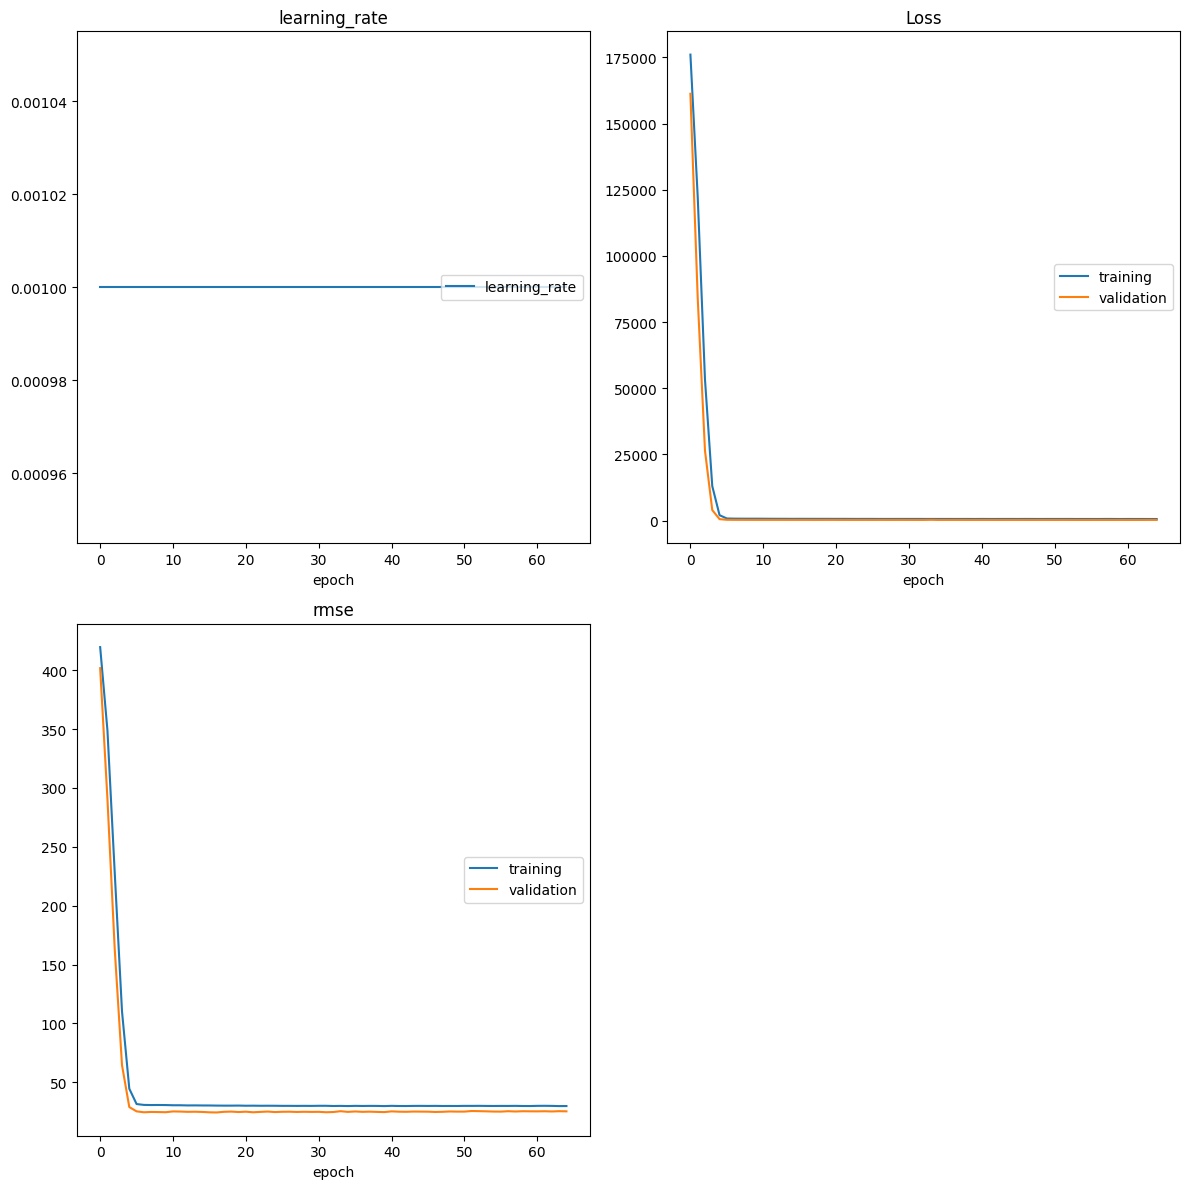

learning_rate
	learning_rate    	 (min:    0.001, max:    0.001, cur:    0.001)
Loss
	training         	 (min:  578.166, max: 176087.906, cur:  578.166)
	validation       	 (min:  223.243, max: 161298.391, cur:  226.808)
rmse
	training         	 (min:   29.815, max:  419.540, cur:   29.858)
	validation       	 (min:   24.413, max:  401.688, cur:   25.364)
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 582.3527 - rmse: 29.9558 - val_loss: 226.8083 - val_rmse: 25.3644 - learning_rate: 0.0010


In [29]:
# Compile the model
model.compile(optimizer='adam', 
              loss='mean_squared_error', 
              metrics=[rmse])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
checkpoint = ModelCheckpoint('cnn_best_model.keras', monitor='val_loss', save_best_only=True)

plot_losses = PlotLossesKeras()

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, 
                    callbacks=[early_stopping, reduce_lr, checkpoint, plot_losses])



In [30]:
# Make predictions on the test set
y_pred_val = model.predict(X_val)

# Calculate R² score using sklearn
r2 = r2_score(y_val, y_pred_val)
print(f"R² score: {r2}")

# Calculate RMSE
rmse_value = np.sqrt(mean_squared_error(y_val, y_pred_val))
print(f"RMSE: {rmse_value}")

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
R² score: 0.48688537504630036
RMSE: 15.021059608281881


## Training on Full Training Set

In [32]:
# Define the model
final_model = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.2),

    Conv1D(128, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.2),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(1)  # Output layer for regression
])

final_model.summary()

/Users/annasmith/anaconda3/envs/irp/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 104, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 104, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 52, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 52, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 50, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 50, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 436,097 (1.66 MB)

 Trainable params: 435,457 (1.66 MB)

 Non-trainable params: 640 (2.50 KB)

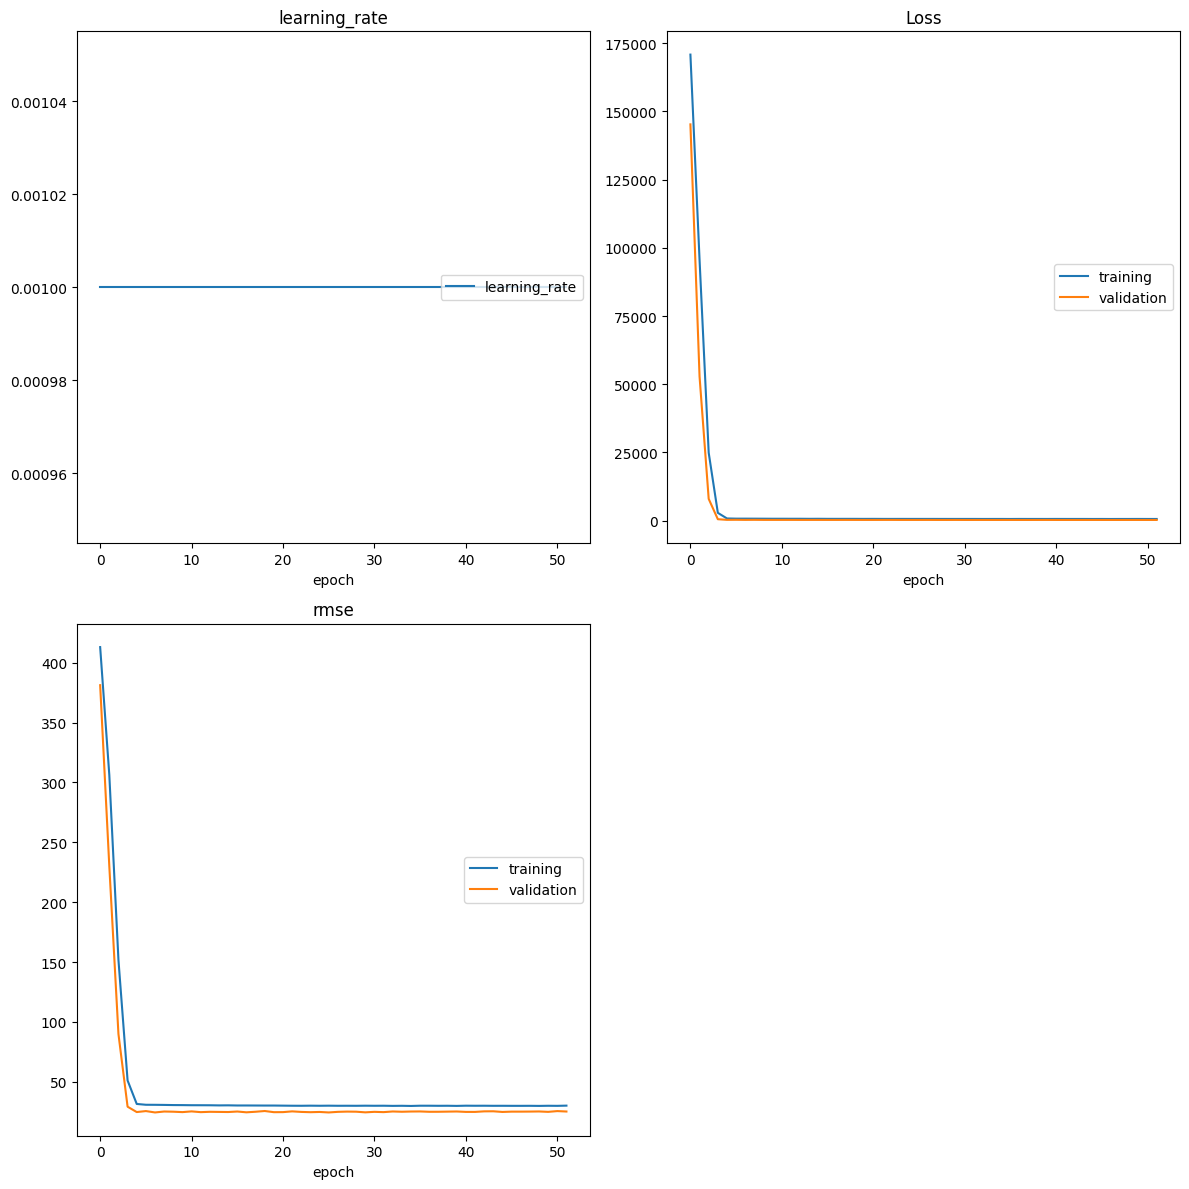

learning_rate
	learning_rate    	 (min:    0.001, max:    0.001, cur:    0.001)
Loss
	training         	 (min:  581.318, max: 170844.969, cur:  590.261)
	validation       	 (min:  229.297, max: 145263.875, cur:  234.040)
rmse
	training         	 (min:   29.766, max:  413.083, cur:   30.030)
	validation       	 (min:   24.333, max:  381.272, cur:   25.117)
439/439 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 591.6248 - rmse: 30.3633 - val_loss: 234.0404 - val_rmse: 25.1168 - learning_rate: 0.0010


In [33]:
# Compile the model
final_model.compile(optimizer='adam', 
              loss='mean_squared_error', 
              metrics=[rmse])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
checkpoint = ModelCheckpoint('final_1D_cnn.keras', monitor='val_loss', save_best_only=True)

plot_losses = PlotLossesKeras()

# Train the model
final_history = final_model.fit(X_train_full, y_train_full, epochs=100, batch_size=64, validation_split=0.2, 
                    callbacks=[early_stopping, reduce_lr, checkpoint, plot_losses])



In [34]:
# # Make predictions on the test set
y_pred_test = final_model.predict(X_test)

# # Calculate R² score using sklearn
r2 = r2_score(y_test, y_pred_test)
print(f"R² score: {r2}")

# # Calculate RMSE
rmse_value = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE: {rmse_value}")

275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
R² score: 0.4958879682591807
RMSE: 15.019733967167047
